<a href="https://colab.research.google.com/github/thalankiabhishek/FetalHealth/blob/main/fetal_health_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle; cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d andrewmvd/fetal-health-classification; unzip fetal-health-classification.zip

  0% 0.00/45.8k [00:00<?, ?B/s]
100% 45.8k/45.8k [00:00<00:00, 16.9MB/s]
Archive:  fetal-health-classification.zip
  inflating: fetal_health.csv        


## Import Libraries and Dataset

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, accuracy_score

In [5]:
df = pd.read_csv('fetal_health.csv')
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
df.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

## Statistical Analysis

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


### Univariate Analysis

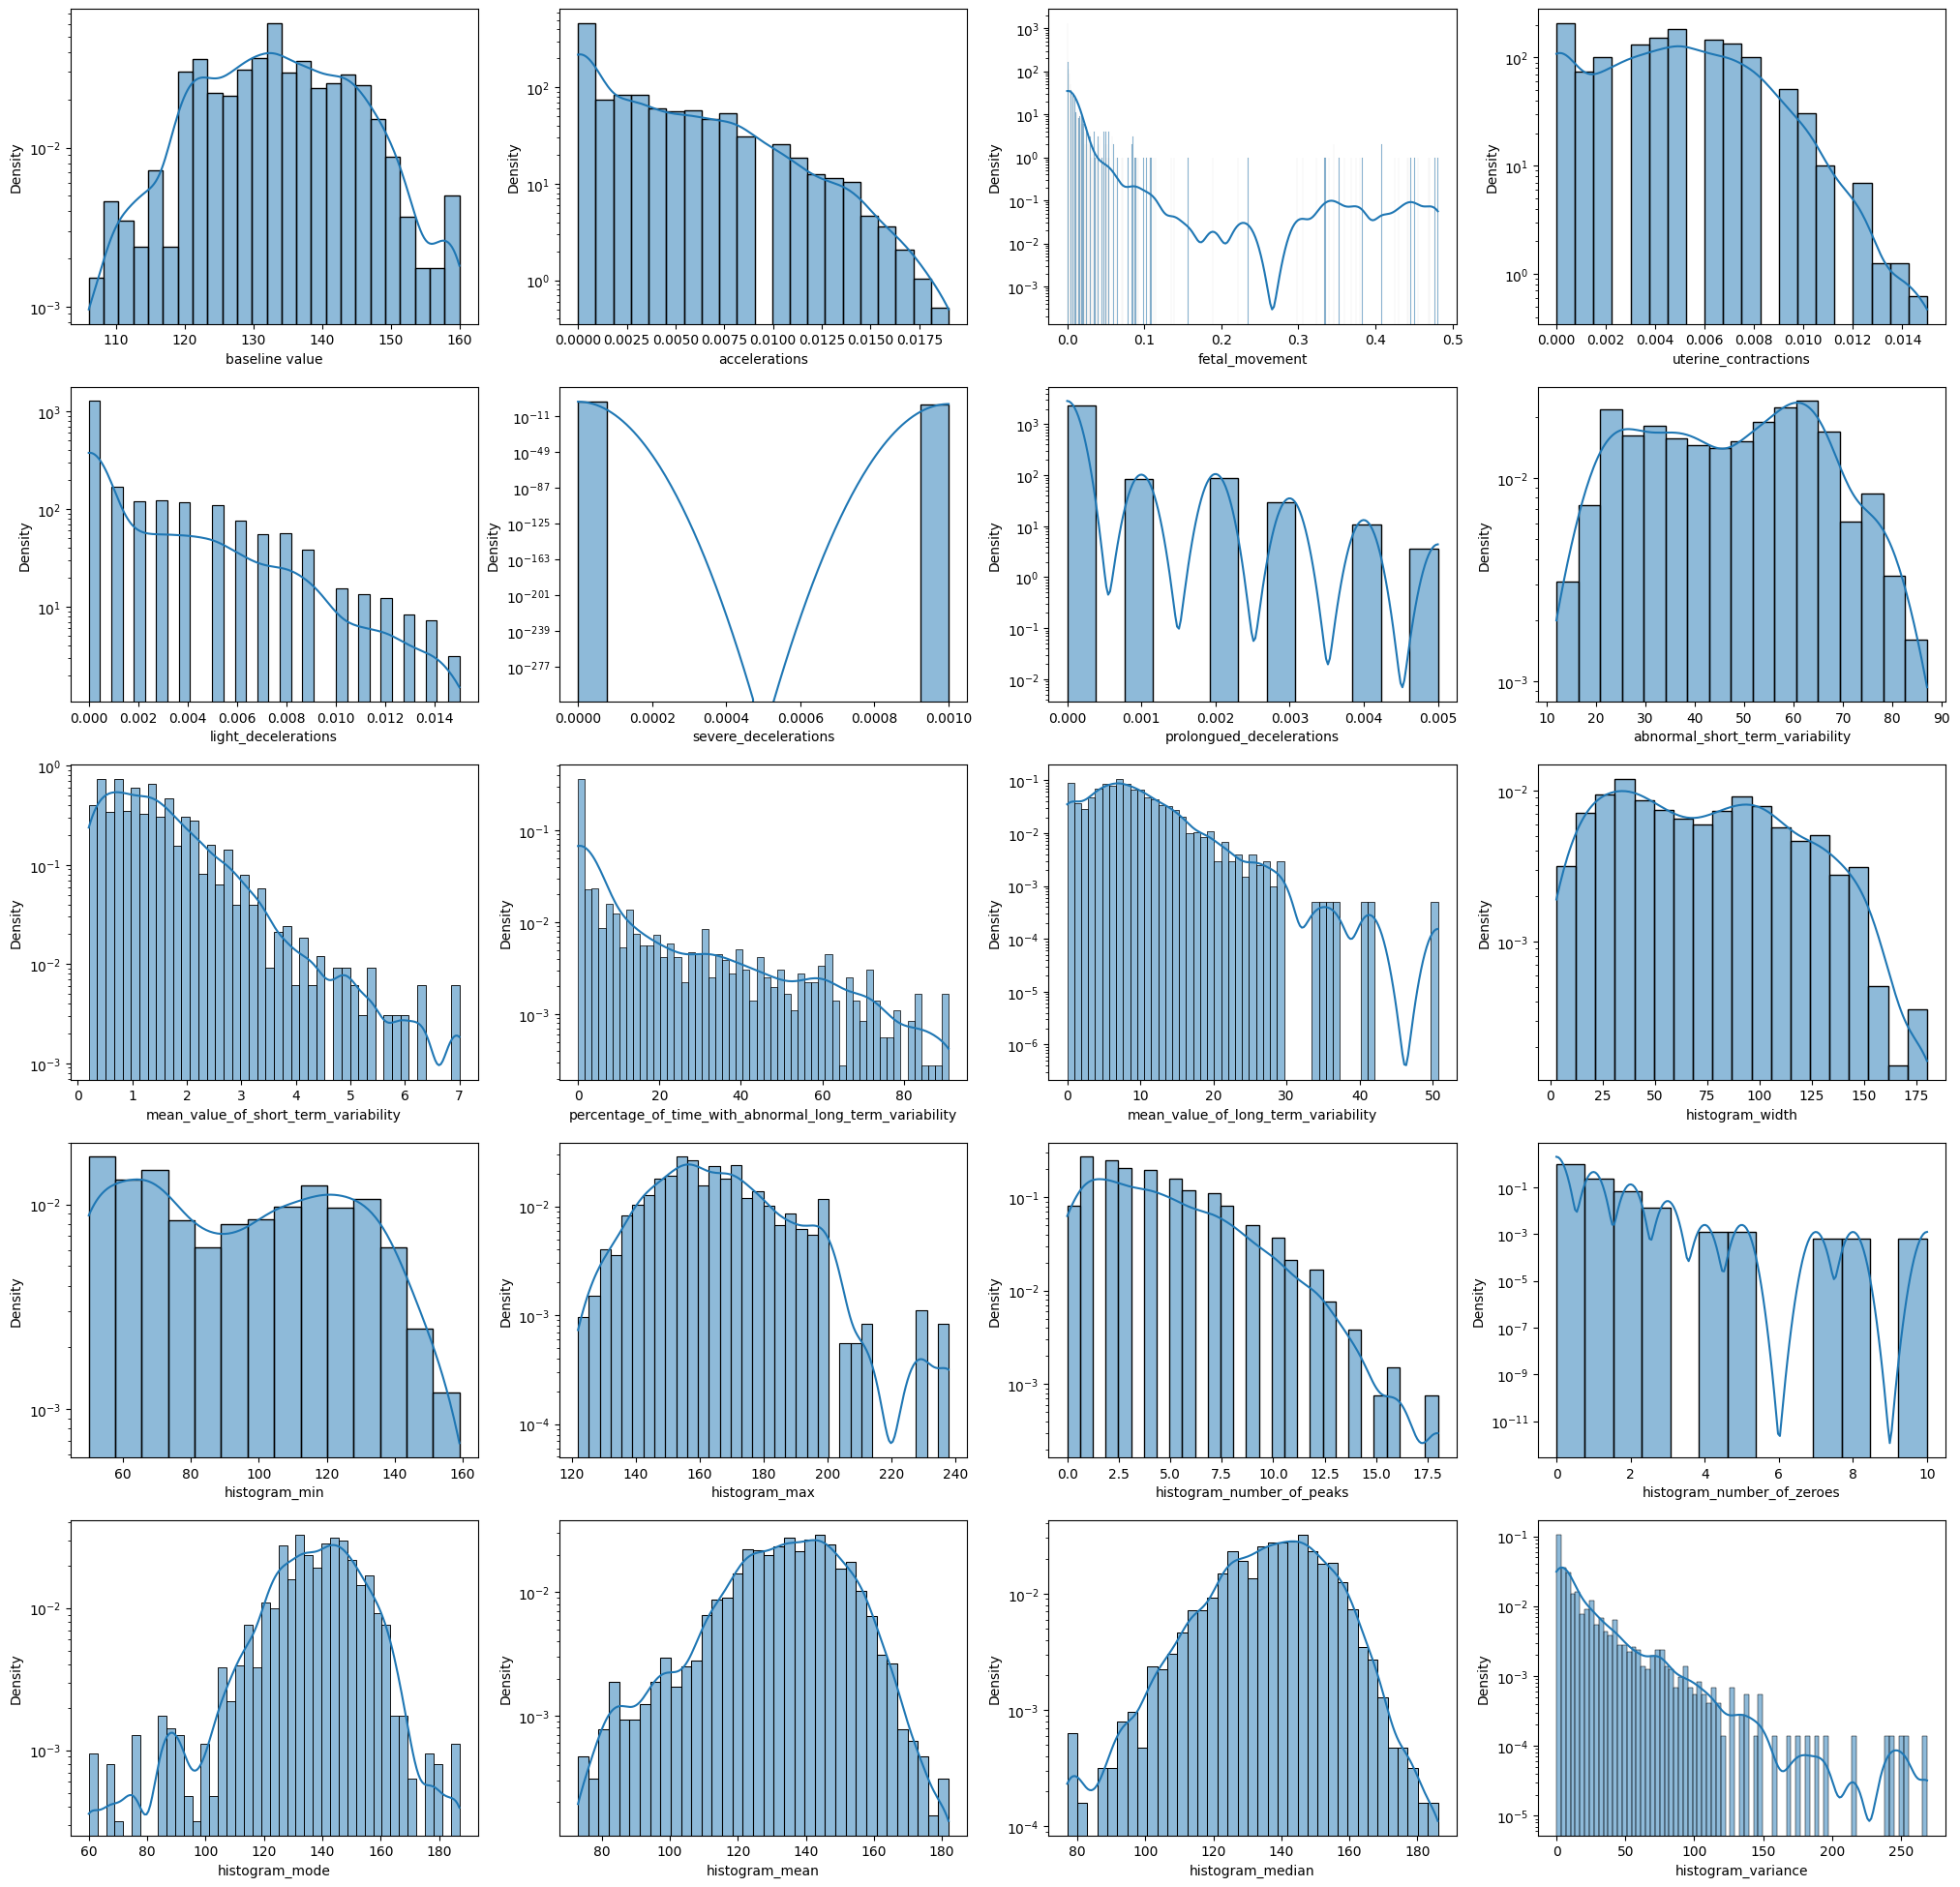

In [8]:
f, a = plt.subplots(nrows=5, ncols=4, figsize=(25, 25), dpi=100, )
for ax, col in zip(a.flatten(), df.columns):
  sns.histplot(data=df, x=col, kde=True, ax=ax, stat='density').set(yticks=[], yscale='log')

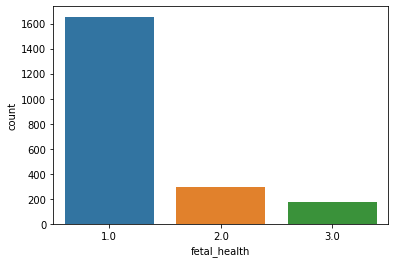

In [13]:
sns.countplot(data=df, x='fetal_health')

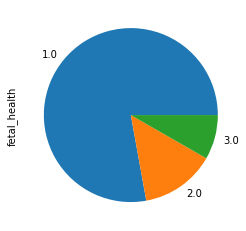

In [11]:
df.fetal_health.value_counts().plot.pie()

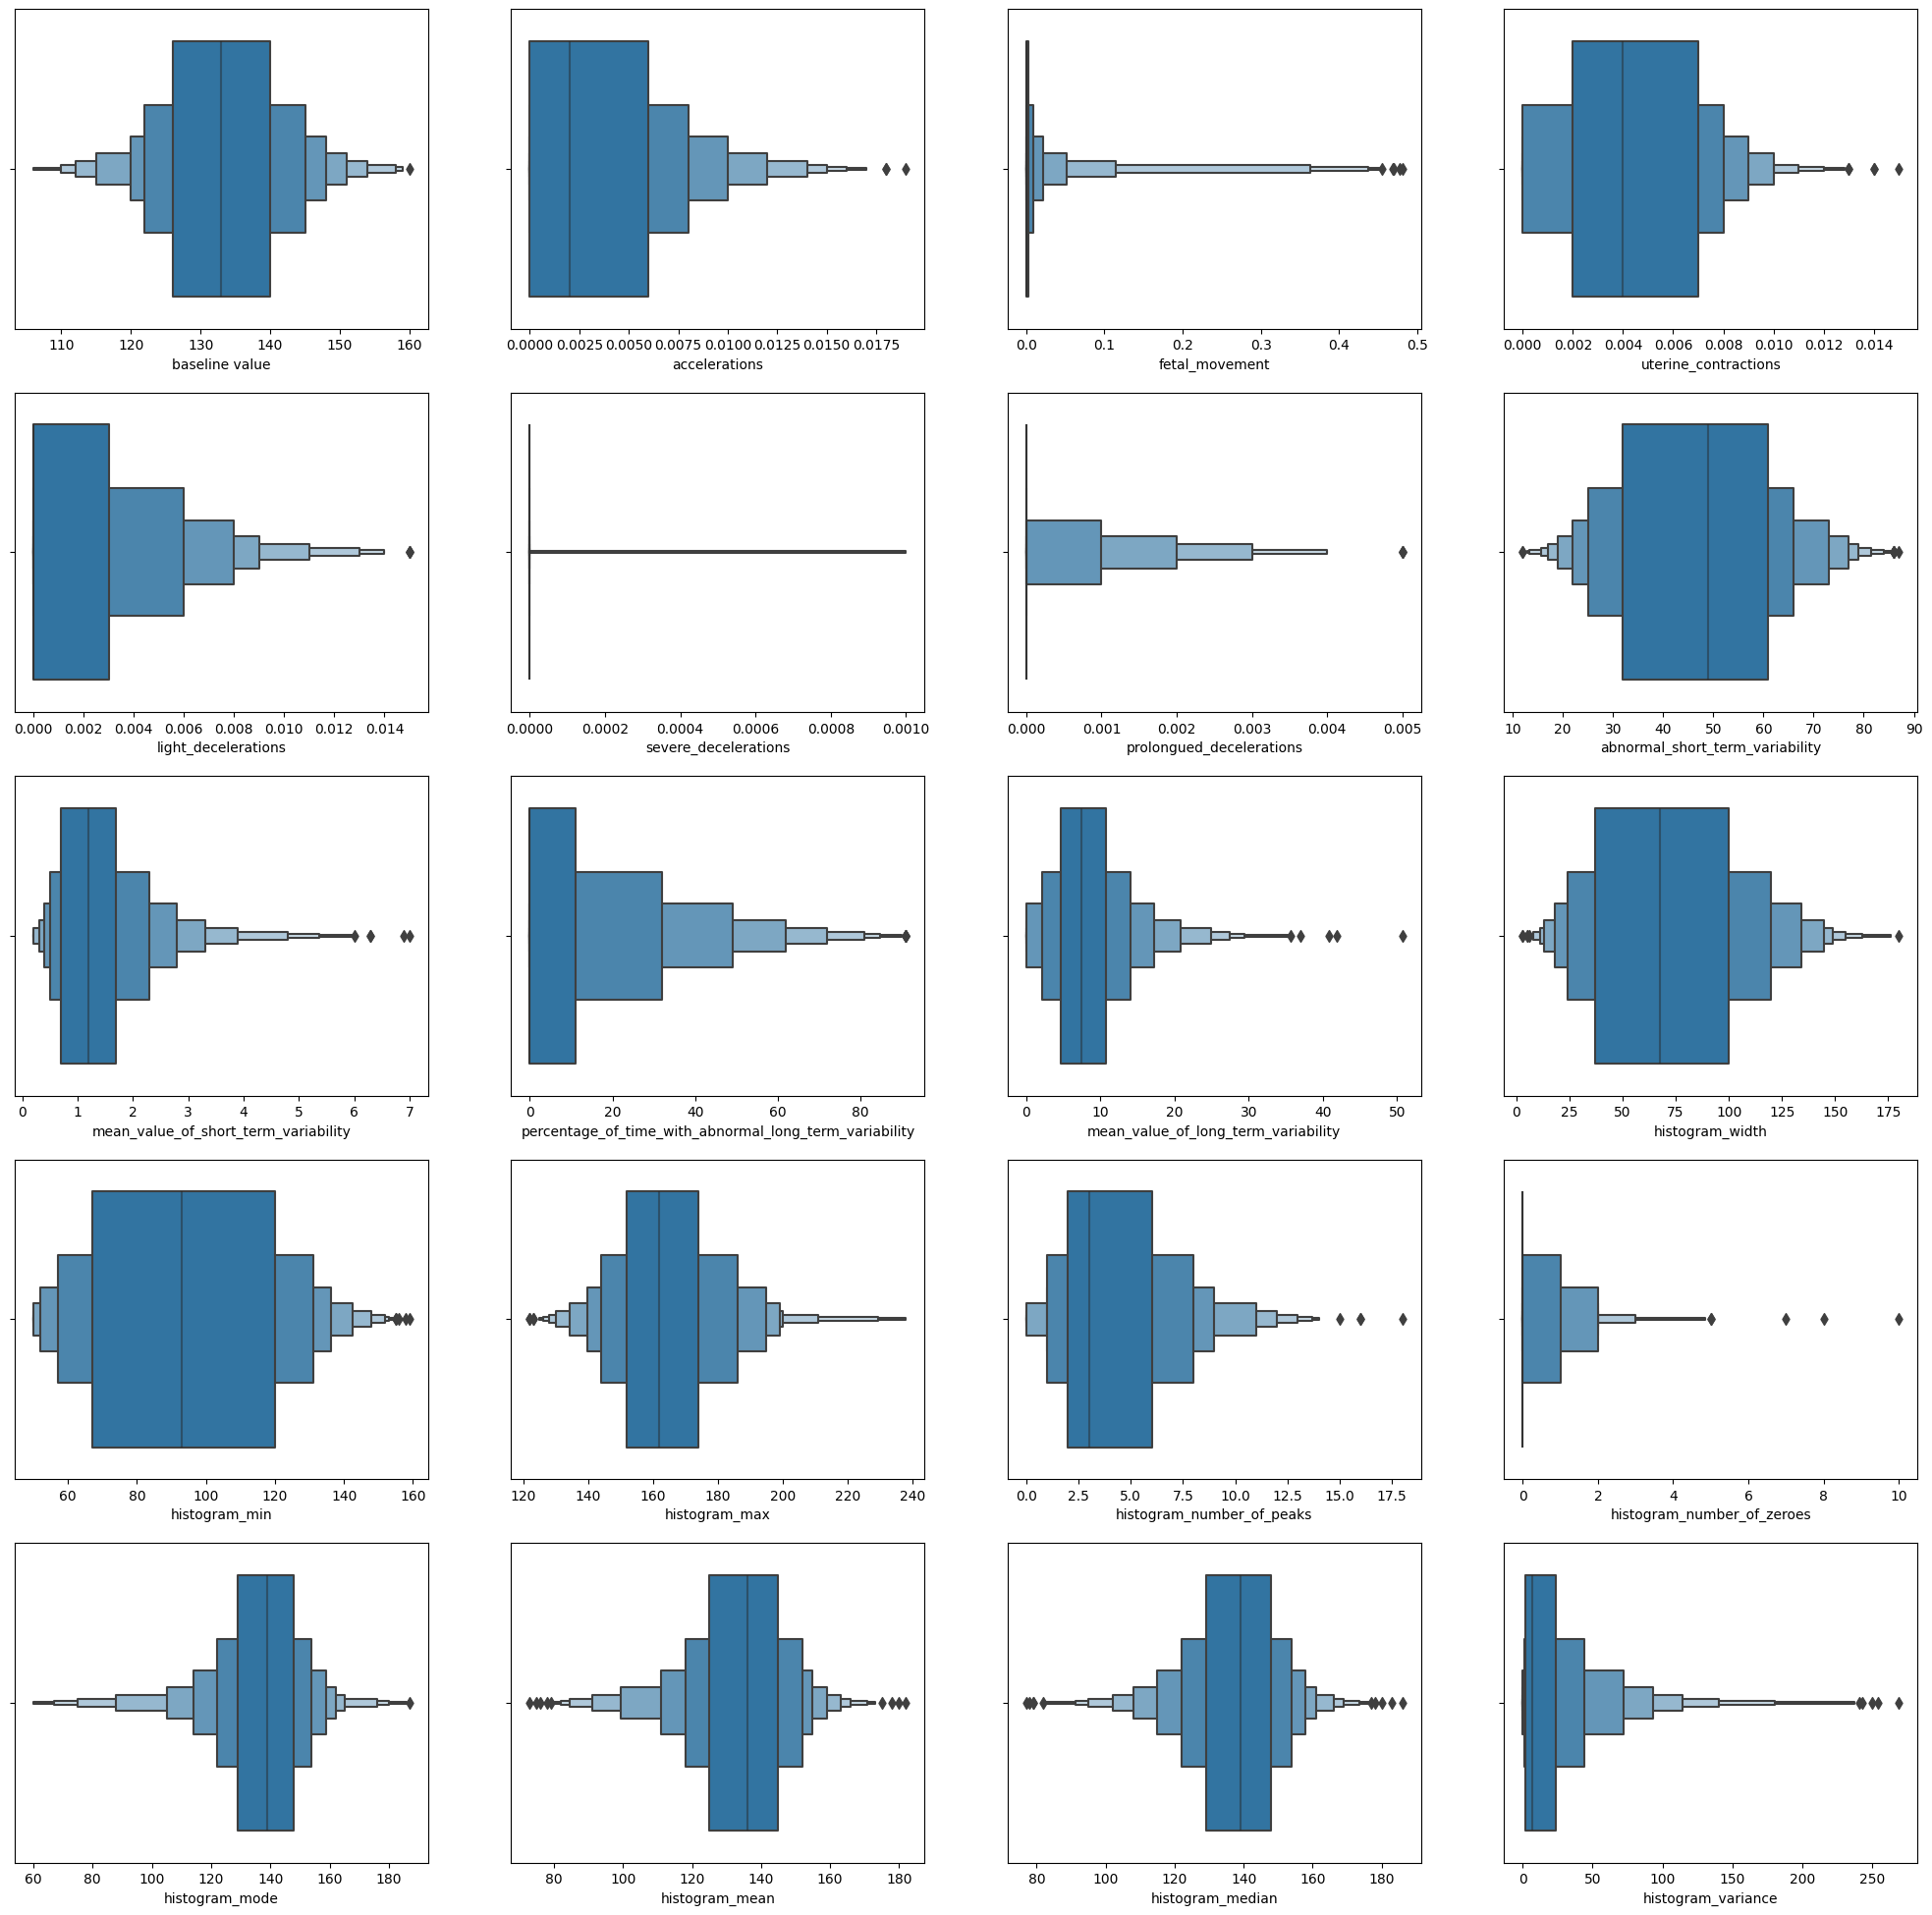

In [14]:
f, a = plt.subplots(nrows=5, ncols=4, figsize=(25, 25), dpi=100, )
for ax, col in zip(a.flatten(), df.columns):
  sns.boxenplot(data=df, x=col, ax=ax)

### Bivariate Analysis

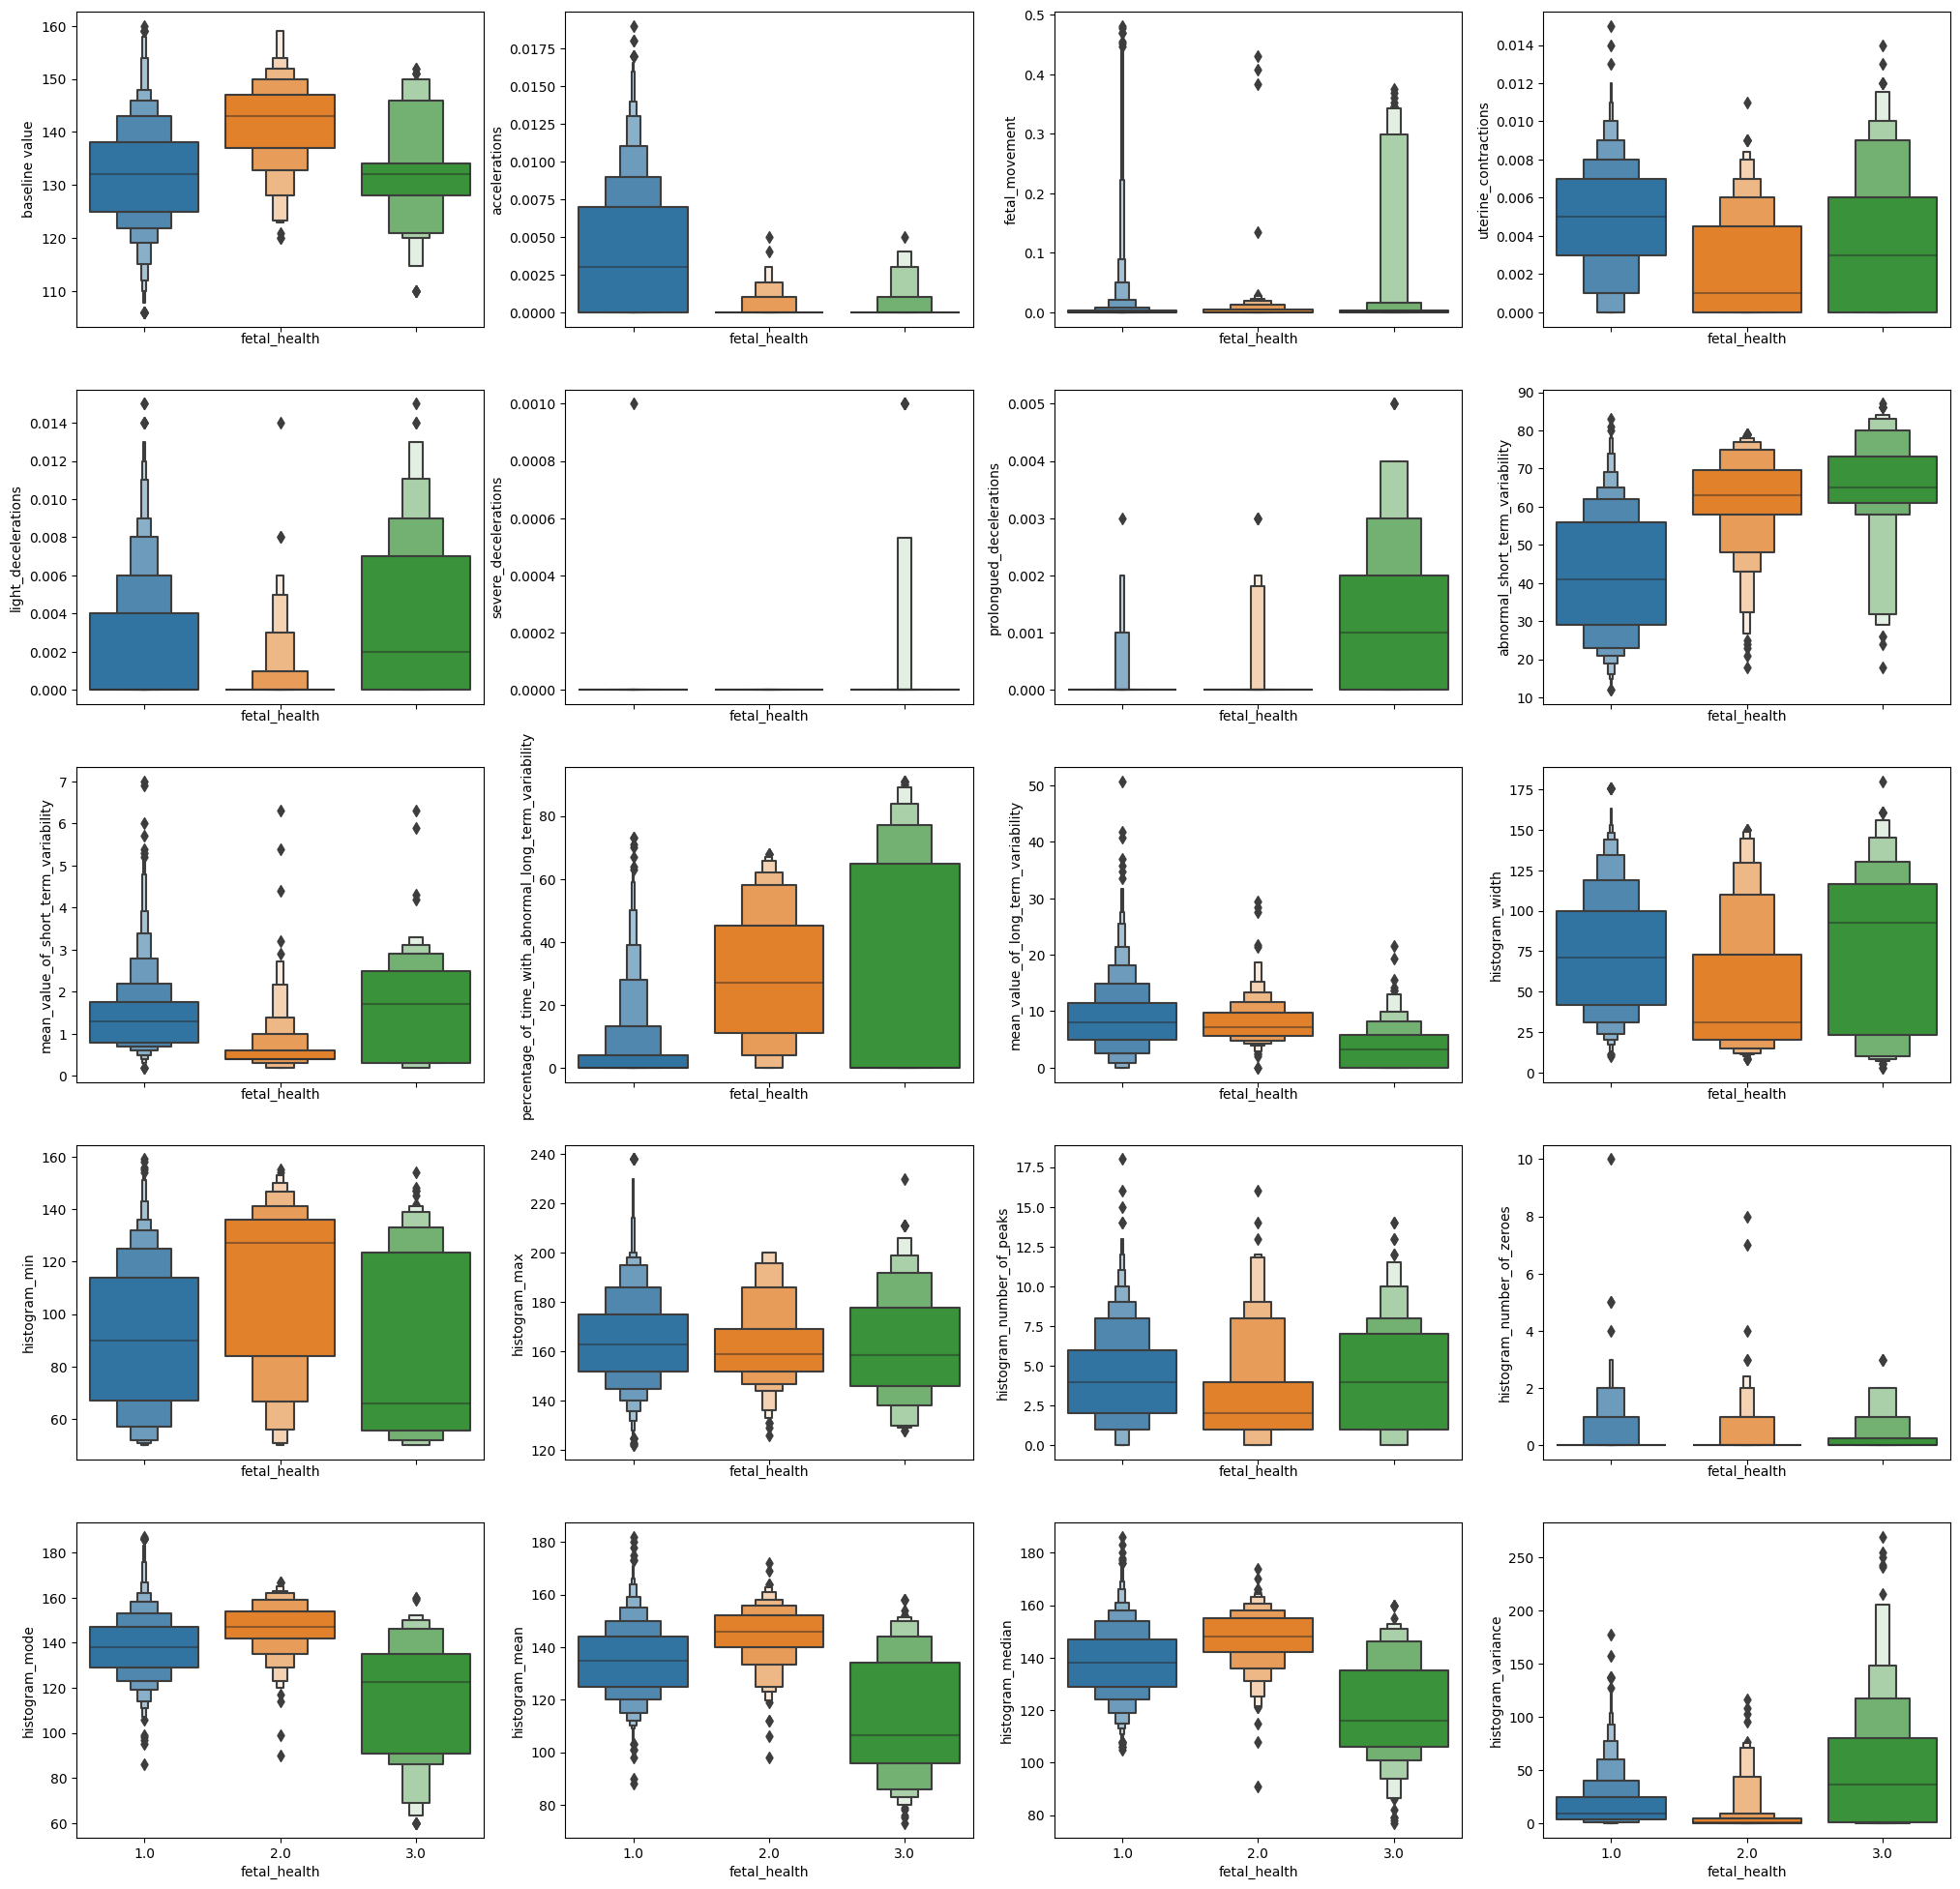

In [15]:
f, a = plt.subplots(nrows=5, ncols=4, figsize=(25, 25), dpi=100, sharex=True)
for ax, col in zip(a.flatten(), df.columns):
  sns.boxenplot(data=df, x='fetal_health', y=col, ax=ax)

### Multivariate Analysis

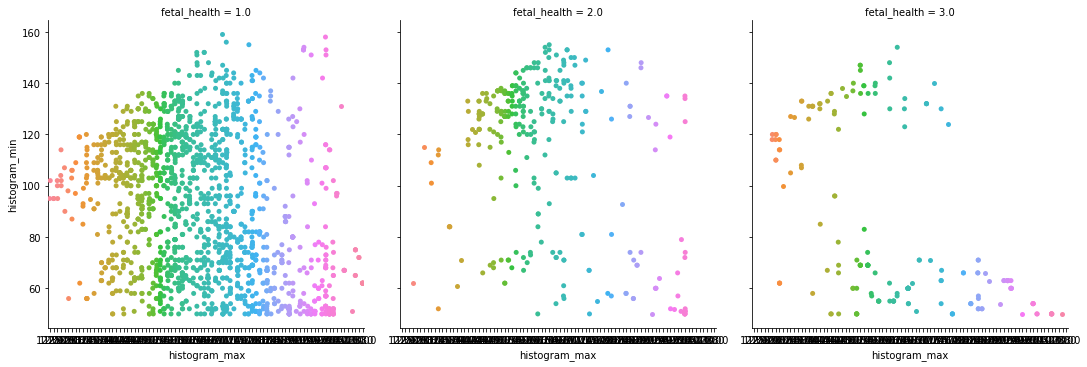

In [28]:
sns.catplot(data=df, x='histogram_max', y='histogram_min', col='fetal_health', )

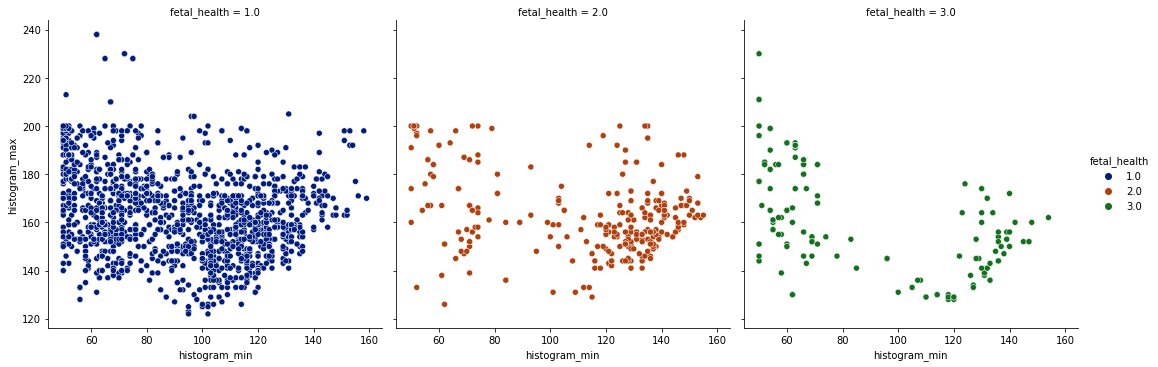

In [44]:
sns.relplot(data=df, x='histogram_min', y='histogram_max', col='fetal_health', hue='fetal_health', palette='dark')

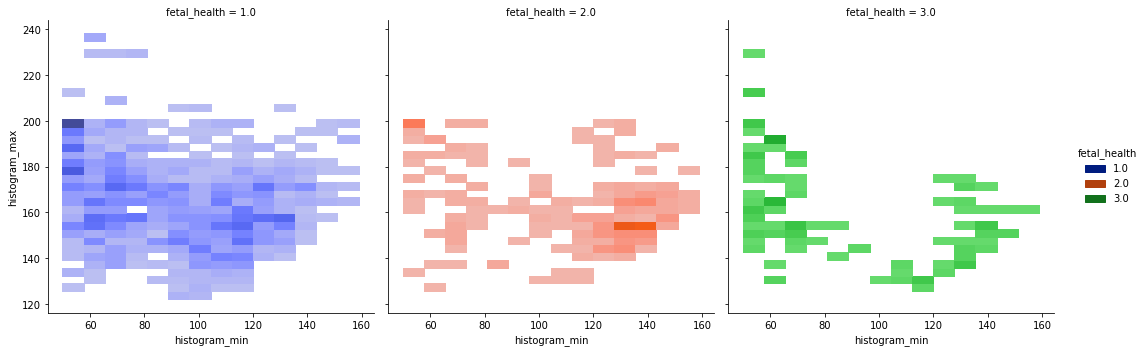

In [45]:
sns.displot(data=df, x='histogram_min', y='histogram_max', col='fetal_health', hue='fetal_health', palette='dark')

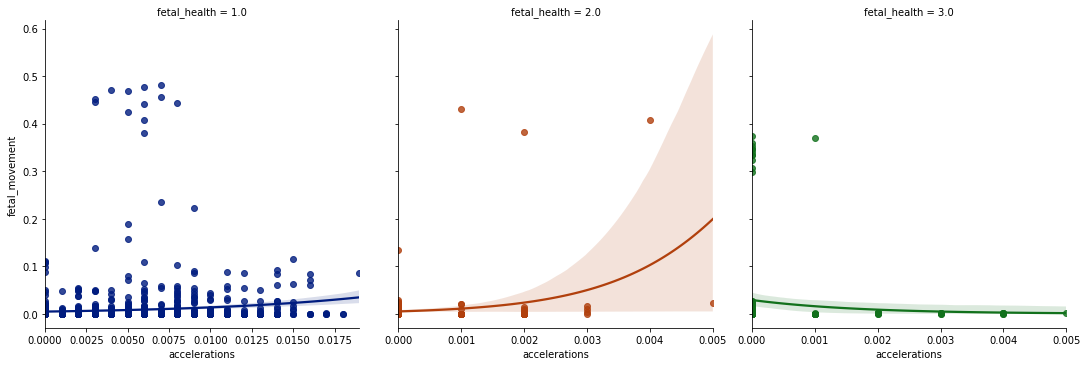

In [58]:
sns.lmplot(data=df, x="accelerations", y="fetal_movement", 
           palette='dark', hue="fetal_health", col="fetal_health", 
           legend_out=True, sharex=False, logistic=True)

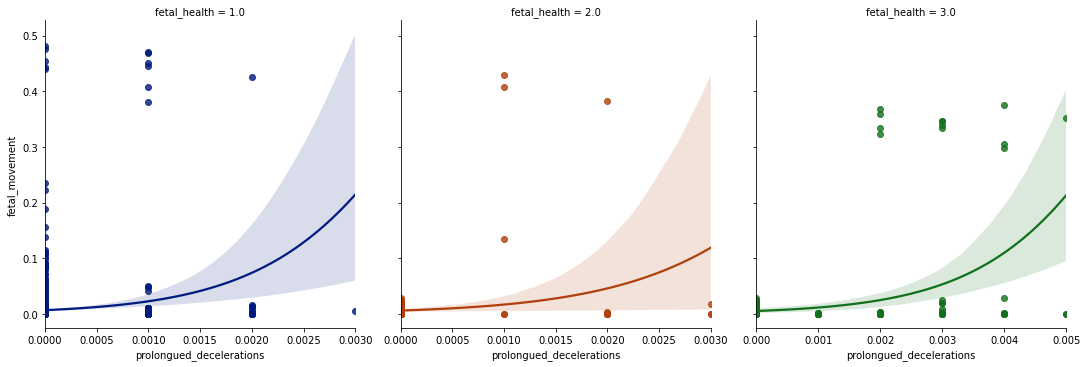

In [59]:
sns.lmplot(data=df, x="prolongued_decelerations", y="fetal_movement", 
           palette='dark', hue="fetal_health", col="fetal_health", 
           legend_out=True, sharex=False, logistic=True)

In [56]:
df.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

## Modelling

### Pre-Processing

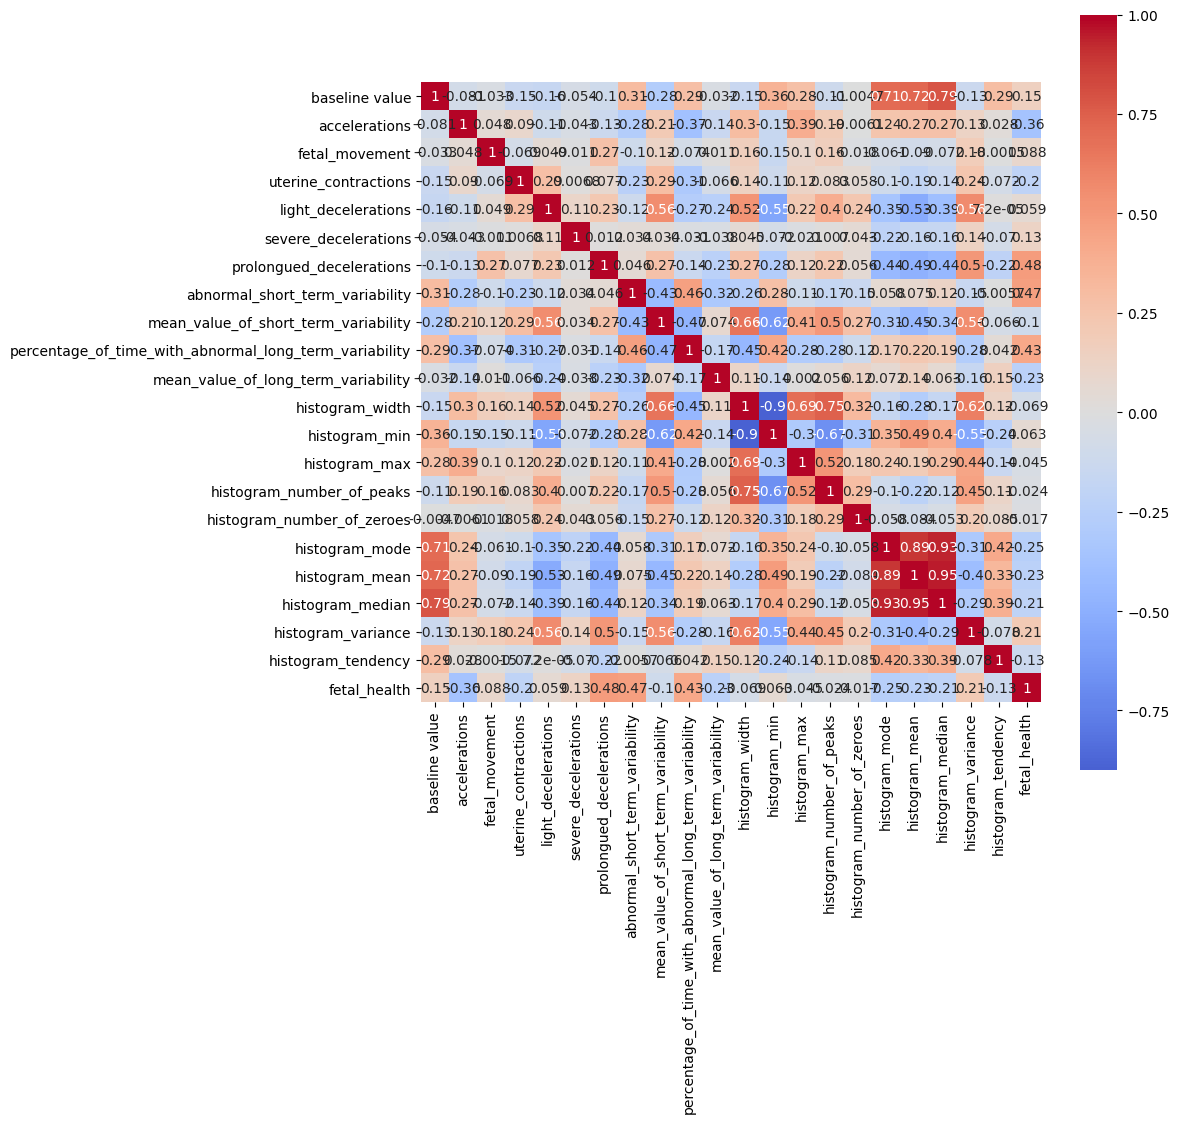

In [50]:
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(df.corr(),annot=True, cmap='coolwarm', center=0, square=True)

[Text(0.5, 1.0, 'Feature correlation')]

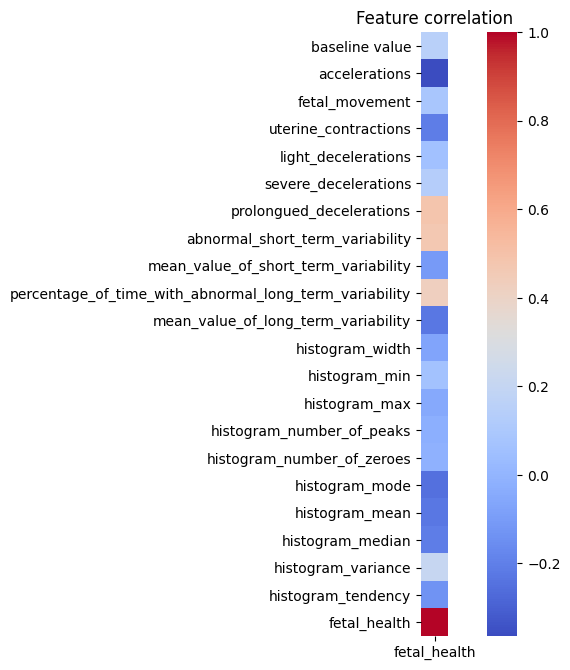

In [175]:
plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(df.corr().sort_values(by=["fetal_health"], ascending=False).head(1).T, cmap="coolwarm", square=True).set(title = "Feature correlation")

In [181]:
abs(df.corr().sort_values(by=["fetal_health"], ascending=False).head(1).T)

,fetal_health
baseline value,0.148151
accelerations,0.364066
fetal_movement,0.088010
uterine_contractions,0.204894
light_decelerations,0.058870
severe_decelerations,0.131934
prolongued_decelerations,0.484859
abnormal_short_term_variability,0.471191
mean_value_of_short_term_variability,0.103382
percentage_of_time_with_abnormal_long_term_variability,0.426146


In [ ]:
from sklearn.feature_selection import SelectKBest #Feature Selector
from sklearn.feature_selection import f_classif #F-ratio statistic for categorical values

In [ ]:
#Feature Selection
X=fetal.drop(['fetal_health'], axis=1)
Y=fetal['fetal_health']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

#Visualize the feature scores
fig, ax=plt.subplots(figsize=(7,7))
plot=sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis',linewidth=0.5, saturation=2, orient='h')
Plotter(plot, 'Score', 'Feature', legend=False, save=True, save_name='Feature Importance.png')#Plotter function for aesthetics
plot

In [62]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

### Processing

In [74]:
# List of all the Model Pipelines
models = [Pipeline([('scaler', StandardScaler()), ('Logistic Regression', LogisticRegression())]), 
          Pipeline([('scaler', StandardScaler()), ('Decision Tree Classifier', DecisionTreeClassifier())]), 
          Pipeline([('scaler', StandardScaler()), ('Random Forest Classifier', RandomForestClassifier())]), 
          Pipeline([('scaler', StandardScaler()), ('K-Neighbors Classifier', KNeighborsClassifier())]), 
          Pipeline([('scaler', StandardScaler()), ('Support Vector Classifier', SVC())])]

In [135]:
# Fit the pipelines
results_accuracy = pd.DataFrame(columns=[models[i].steps[-1][0] for i in range(len(models))], 
                                index=['Training Cross Validation Score', 'Testing Cross Validation Score', 'Accuracy'])

for i, model in enumerate(models):
  model.fit(X_train, y_train)

  results_accuracy[models[i].steps[-1][0]]['Training Cross Validation Score'] = cross_val_score(model, X_train, y_train, cv=10).mean()
  results_accuracy[models[i].steps[-1][0]]['Testing Cross Validation Score'] = cross_val_score(model, X_test, y_test, cv=10).mean()
  results_accuracy[models[i].steps[-1][0]]['Accuracy'] = accuracy_score(y_test, model.predict(X_test))
  
results_accuracy = results_accuracy.T.sort_values(by=['Training Cross Validation Score', 'Accuracy'], ascending=False)
results_accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,Training Cross Validation Score,Testing Cross Validation Score,Accuracy
Random Forest Classifier,0.944178,0.919078,0.930451
Decision Tree Classifier,0.922205,0.887107,0.917293
Support Vector Classifier,0.91783,0.888994,0.909774
K-Neighbors Classifier,0.904049,0.874004,0.881579
Logistic Regression,0.894002,0.888994,0.890977


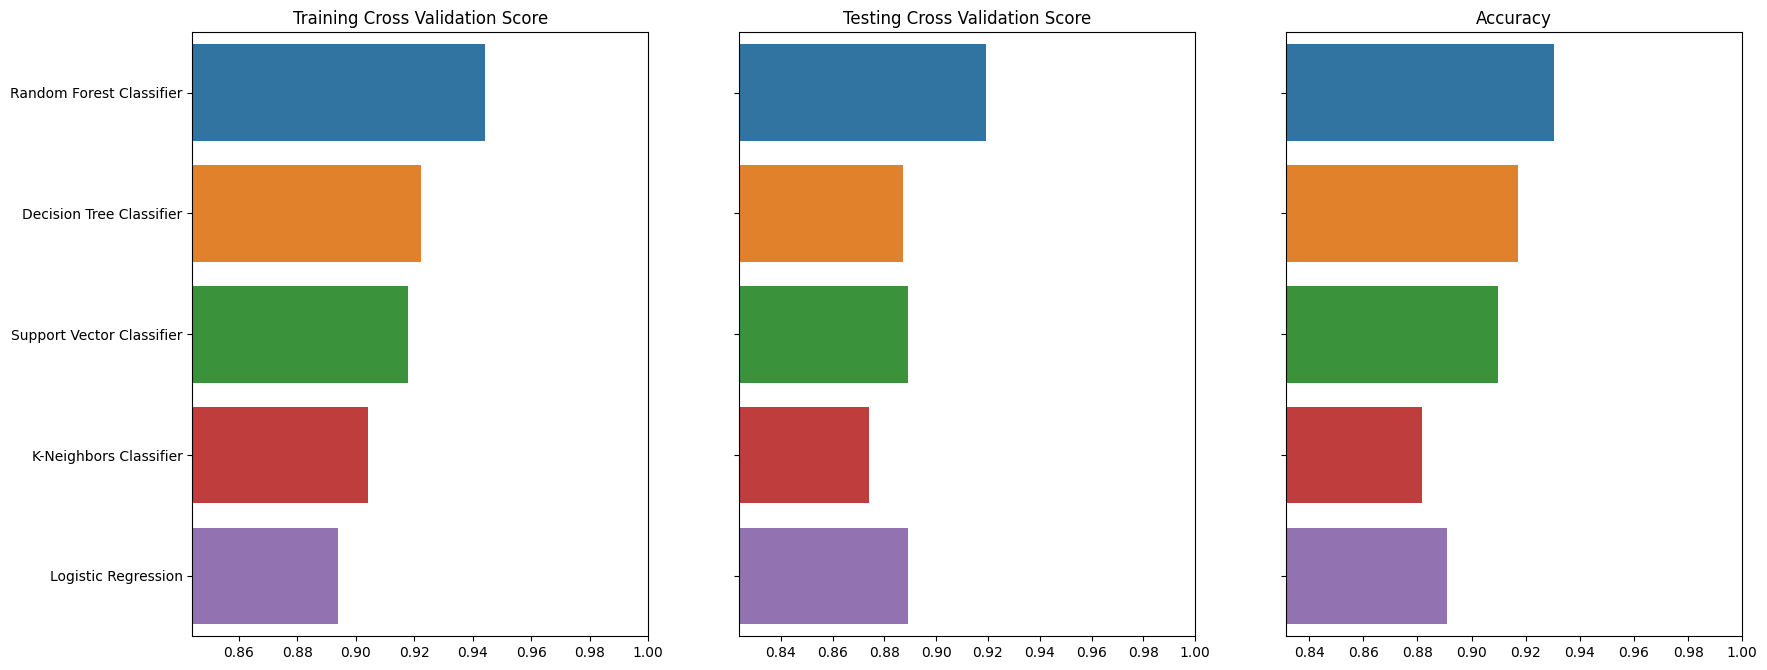

In [152]:
f, a = plt.subplots(ncols=3, figsize=(20, 8), dpi=100, sharey=True)
for ax, col in zip(a.flatten(), results_accuracy.columns):
  sns.barplot(x=results_accuracy[col].values, y=results_accuracy[col].keys(), ax=ax)
  ax.set(title=col, xlim=(min(results_accuracy[col])-0.05, 1))

### Evaluation

In [153]:
from sklearn.model_selection import GridSearchCV

In [178]:
#Building a dictionalry with list of optional values that will me analyesed by GridSearch CV
parameters = { 
    'n_estimators': [100, 150, 200, 500, 700, 900],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8,12,14,16],
    'criterion' :['gini', 'entropy'],
    'n_jobs': [-1]
}

In [180]:
#Fitting the trainingset to find parameters with best accuracy
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), 
                      param_grid=parameters, 
                      cv= 5,
                      verbose=1, 
                      n_jobs=-1,
                      scoring="accuracy", 
                      return_train_score=True)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 14.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [182]:
#Getting the outcome of gridsearch
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'max_features': 'log2',
 'n_estimators': 150,
 'n_jobs': -1}

In [183]:
RF_model = RandomForestClassifier(**CV_rfc.best_params_)
RF_model.fit(X_train, y_train)

#Testing the Model on test set
predictions=RF_model.predict(X_test)
accuracy_score(y_test,predictions)

0.9266917293233082

### Visualising results

In [184]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc, roc_auc_score

In [197]:
print("********* Random Forest Results *********")
print("Accuracy    : ", accuracy_score(y_test,predictions))
print("Recall      : ", recall_score(y_test,predictions, average='weighted'))
print("Precision   : ", precision_score(y_test,predictions, average='weighted'))
print("F1 Score    : ", f1_score(y_test,predictions, average='weighted'))

********* Random Forest Results *********
Accuracy    :  0.9266917293233082
Recall      :  0.9266917293233082
Precision   :  0.9269629039093596
F1 Score    :  0.9220724437260843


In [198]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.99      0.96       406
         2.0       0.93      0.65      0.76        85
         3.0       0.88      0.93      0.90        41

    accuracy                           0.93       532
   macro avg       0.92      0.85      0.88       532
weighted avg       0.93      0.93      0.92       532



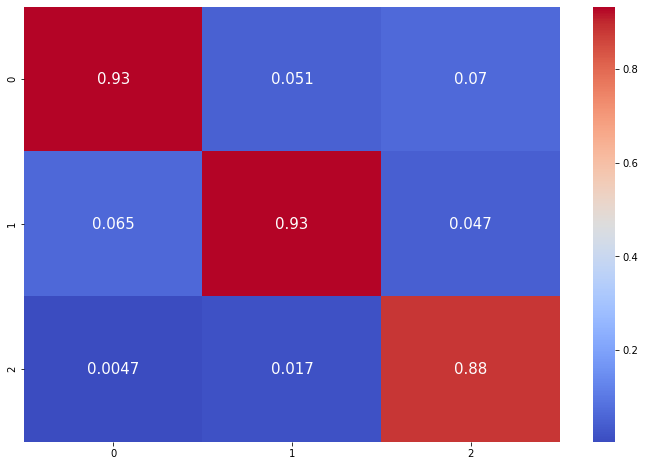

In [199]:
# cofusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/sum(cf_matrix), cmap='coolwarm',annot = True, annot_kws = {'size':15})

In [200]:
!git branch -M main; git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
